# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `32`
* Students: `George Adaimi, Okan Altingovde, Isinsu Katircioglu, Sena Kiciroglu`
* Dataset: `FMA`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [104]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [216]:
adjacency =  np.load('adjacency_noDisconnectedNodes_mfccStdMeanSkewKurtosisMedian.npy')# the adjacency matrix
n_nodes =  adjacency.shape[0]# the number of nodes in the network
n_edges =  np.count_nonzero(adjacency)//2# the number of edges in the network
print('Number of nodes: ', n_nodes)
print('Number of edges: ', n_edges)

Number of nodes:  2000
Number of edges:  662928


## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [217]:
D = np.diag(adjacency.sum(axis=1))
L = D - adjacency
laplacian_combinatorial =  sparse.csr_matrix(L)

sqrt_D = np.power(np.linalg.inv(D),0.5)
laplacian_normalized = sparse.csr_matrix(sqrt_D@L@sqrt_D)

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [218]:
laplacian =  laplacian_normalized

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(laplacian.todense())

assert eigenvectors.shape == (n_nodes, n_nodes)

## Sorting Eigenvalues and EigenVectors
sorted_indexes = eigenvalues.argsort()
eigenvalues = eigenvalues[sorted_indexes]
eigenvectors = eigenvectors[sorted_indexes]

Justify your choice of eigensolver.

**Our answer:**
* We choose numpy's eigensolver since we want to compute eigenvalues for all eigenvectors which is not possible with scipy sparse eigensolver.

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

**Our answer:** 

If L is the unnormalized laplacian, then S is the incidence matrix with its elements:

$$S(i,j) = \left\{\begin{matrix}
 +1& \text{if } e_j=(v_i,v_k) \text{ for some } k \\ 
 -1& \text{if } e_j=(v_k,v_i) \text{ for some } k\\ 
 0& otherwise
\end{matrix}\right.$$

In $S^T$ each column corresponds to a node and each row corresponds to an edge. It is used to show which node the edge comes out of and which node the edges goes to. Meaning that, in $S^T$ there is always a -1 and a 1 in each row and the rest of the elements are 0. Therefore when we do $S^Tx$ we do finite-differences between the two nodes that are associated with an edge. The result is a (edge_num x 1) column vector.


### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Our answer:**

The eigenvalue equation for the Laplacian is the following:
$$Lu_k = u_k\lambda_k$$
Since $L = SS^T$
$$SS^Tu_k = u_k\lambda_k\\
u_k^{-1}SS^Tu_k = u_k^{-1}u_k\lambda_k \\
u_k^{-1}SS^Tu_k = \lambda_k
$$

We can say $u_k^{-1} = u_k^{T}$ for eigenvectors. Therefore
$$u_k^{T}SS^Tu_k = \lambda_k\\
\| S^T u_k \|_2^2 = \lambda_k$$

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

**Our answer:**

This quantity corresponds to $x^TSS^Tx = x^TLx$. This is a quality that measures how the function x changes. For example, the result is big if the there is a difference between x[i] and x[j] with a large weight W[i,j] on the edge between them.

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

In [203]:
eigenvalues_c, eigenvectors_c = np.linalg.eig(laplacian_combinatorial.todense())
sorted_indexes_c = eigenvalues_c.argsort()
eigenvalues_c = eigenvalues_c[sorted_indexes_c]
eigenvectors_c = eigenvectors_c[sorted_indexes_c]

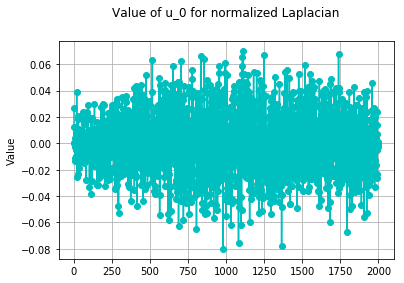

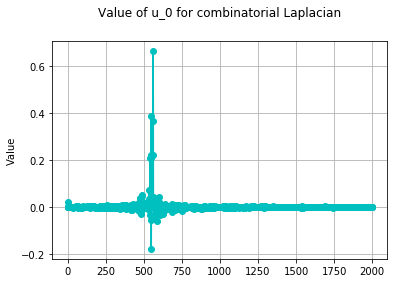

u_0 norm: [ 2.64407436e-02  2.52572478e-04 -2.40099337e-08 ... -3.31622538e-05
  7.34021320e-05 -2.45368376e-04]
u_0 comb: [ 1.31606686e-03  2.23606798e-02 -1.09038069e-03 ... -1.75490266e-04
  4.87036442e-05  1.75790973e-04]


In [204]:
u0_n = np.squeeze(np.asarray(eigenvectors[0]))
u0_c = np.squeeze(np.asarray(eigenvectors_c[0]))


def plot_eigenvector(values, norm= True):
    if norm:
        title = 'Value of u_0 for normalized Laplacian'
    else:
        title = 'Value of u_0 for combinatorial Laplacian'
    values = values[:None]
    fig = plt.figure()
    index = np.arange(len(values))
    ax = fig.add_subplot(1,1,1)
    plt.plot(index, values, label='eigenvalues', color='c', marker='o')
    ax.set_ylabel('Value')
    ax.grid(True)
    plt.title(title, pad=25)
    plt.show()
    plt.close(fig)
    
plot_eigenvector(u0_n, norm = True)
plot_eigenvector(u0_c, norm = False)

print("u_0 norm:", u0_n)
print("u_0 comb:", u0_c)


**Our answer:**
We have plotted the values within $u_0$ above.

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

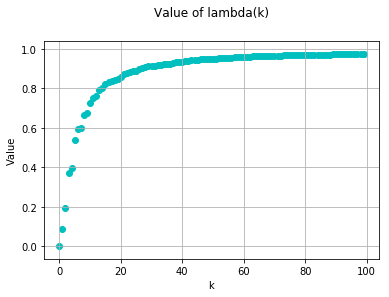

In [205]:
# Your code here.
#0th eigenval should be 0

def plot_spectrum(eigenvalues,with_label,scatter = False,range = None):
    eigenvalues = eigenvalues[:None]
    fig = plt.figure()
    index = np.arange(len(eigenvalues))
    ax = fig.add_subplot(1,1,1)
    ax.set_facecolor((1.0, 1.0, 1.0))

    ax.set_ylabel('Value')
    plt.ylabel('Value')
    plt.xlabel('k')
    ax.grid(True)

    if with_label:
        for x, eigenvalue in zip(index,eigenvalues):
            ax.annotate('%.2f'%(eigenvalue), (x,eigenvalue))
    if not scatter:
        plt.plot(index, eigenvalues, label='eingenvalues', color='c', marker='o')  
    else:
        plt.scatter(index, eigenvalues, label='eingenvalues', color='c', marker='o')
        
    plt.title('Value of lambda(k)', pad=25)
    plt.show()
    plt.close(fig)
        
plot_spectrum(eigenvalues[:100],scatter=True, with_label=False)   

**Our answer:**
* The smallest eigenvalue is 0 and the next smallest eigenvalue is greater than 0. This shows that the multiplicity of 0 is 1, and we have only 1 connected component in our graph.
* The largest eigenvalue is less than 2.

How many connected components are there in your graph? Answer using the eigenvalues only.

In [206]:
# Your code here.
#we count the number of eigenvalues with value 0
def get_numbConnectedComp(eigenvalues):
    return np.sum(np.round(eigenvalues,decimals=2) == 0)

print("The number of connected components:", get_numbConnectedComp(eigenvalues))

The number of connected components: 1


Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**Our answer:**
* The upperbound for the normalized Laplacian's largest eigenvalue is 2. It can be equal to 2 if and only if the graph is bipartite. 
* There is no upperbound for the combanitorial Laplacian's largest eigenvalue. **check**

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Our answer:**

We use Laplacian eigenmaps to reduce the dimensionality of the graph. This allows us to process the graph more easily by reducing the dimension while not affecting how the nodes are clustered within the graph.

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [207]:
# Your code here.

def get_LaplacianEigenMaps(laplacian, new_dim =2,use_normalized=True):
    eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, which='SM', k=new_dim+1)
    embeddings = eigenvectors[:,1:new_dim+1]
    if use_normalized:
        return (embeddings.T*np.diag(sqrt_D)).T
    return embeddings

embeddings_c = get_LaplacianEigenMaps(laplacian_combinatorial,use_normalized=False)

embeddings_n = get_LaplacianEigenMaps(laplacian_normalized)

Plot the nodes embedded in 2D. Comment on what you see.

Shape of embedding_c: (2000, 2)
Shape of embedding_n: (2000, 2)


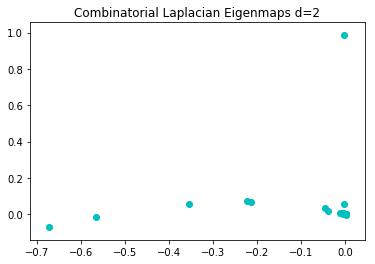

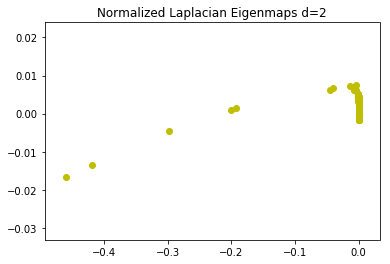

In [208]:
# Your code here.
print('Shape of embedding_c: {}'.format(embeddings_c.shape))
print('Shape of embedding_n: {}'.format(embeddings_n.shape))
fig = plt.figure()
plt.scatter(embeddings_c[:,0],embeddings_c[:,1], label='', color='c', marker='o')
plt.title('Combinatorial Laplacian Eigenmaps d=2')
plt.show()
plt.close(fig)

fig = plt.figure()
plt.scatter(embeddings_n[:,0],embeddings_n[:,1], label='', color='y', marker='o')
plt.title('Normalized Laplacian Eigenmaps d=2')
plt.show()
plt.close(fig)


**Our answer:**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**
* Preserves the relationship between nodes that is it keeps information about how nodes are clustered together. It does not ruin the locality of the nodes.

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**Our answer**
* k=2 because we are using the small version of the FMA dataset which has 2 labels. 

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [209]:
# Your code here.
embeddings_c_100 = get_LaplacianEigenMaps(laplacian_combinatorial, new_dim = 10, use_normalized=False)
embeddings_n_100 = get_LaplacianEigenMaps(laplacian_normalized, new_dim = 10)

#kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings_n_100)
#labels = kmeans.labels_
    
_, temp = sparse.linalg.eigsh(laplacian_normalized, which='SM', k=2)
fiedler_vector_n = temp[:,1]

_, temp = sparse.linalg.eigsh(laplacian_combinatorial, which='SM', k=2)
fiedler_vector_c = temp[:,1]

In [210]:
clusters_n = np.zeros([n_nodes,])
clusters_n[fiedler_vector_n>0] = 1
clusters_n[fiedler_vector_n<=0] = -1

print("When we use normalized Laplacian:")
print("Number of nodes with label 1:", (clusters_n[clusters_n ==1]).shape[0])
print("Number of nodes with label -1:", (clusters_n[clusters_n ==-1]).shape[0])

clusters_c = np.zeros([n_nodes,])
clusters_c[fiedler_vector_c>0] = 1
clusters_c[fiedler_vector_c<=0] = -1

print("\nWhen we use combinatorial Laplacian:")
print("Number of nodes with label 1:", (clusters_c[clusters_c ==1]).shape[0])
print("Number of nodes with label -1:", (clusters_c[clusters_c ==-1]).shape[0])

print("\nSince we have less uneven clustering using the normalized Laplacian, we prefer to keep using this one.")

When we use normalized Laplacian:
Number of nodes with label 1: 1407
Number of nodes with label -1: 593

When we use combinatorial Laplacian:
Number of nodes with label 1: 1985
Number of nodes with label -1: 15

Since we have less uneven clustering using the normalized Laplacian, we prefer to keep using this one.


### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

(2000,)


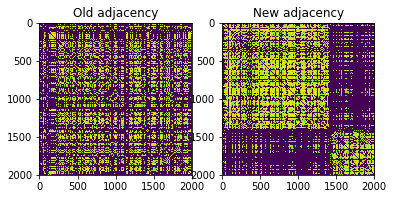

In [211]:
# Your code here.
adjacency_reordered = np.zeros([n_nodes, n_nodes])
n_nodes_1 = clusters_n[clusters_n == 1].shape[0]
ind_nodes_1 = np.where(clusters_n == 1)[0]
ind_nodes_minus_1 = np.where(clusters_n == -1)[0]
indices = np.concatenate([ind_nodes_1, ind_nodes_minus_1])
print(indices.shape)

adjacency_reordered = adjacency[:, indices][indices, :]

fig = plt.figure()
plt.subplot(1,2,1)
plt.imshow(adjacency)
plt.title('Old adjacency')
plt.subplot(1,2,2)
plt.imshow(adjacency_reordered)
plt.title('New adjacency')
plt.show()
plt.close(fig)

**Our answer:**
* We expected to be able to see a clear divide between the two clusters. The top left part of the adjacency should be mostly non-zero, and the bottom right should be mostly non-zero. The rest should be very sparsely filled. This is exactly what we observe. We can see that we have two clusters which are loosely connected together. 

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [212]:
import pandas as pd
import ast
def load(filename):

    if 'features' in filename:
        return pd.read_csv(filename, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filename, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filename, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filename, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                pd.api.types.CategoricalDtype(SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype(pd.api.types.CategoricalDtype())

    return tracks
tracks = load('dataset/tracks.csv') #Read tracks.csv
features = load('dataset/features.csv') # Read features.csv
#Create genre groundtruth array
small = tracks[tracks['set', 'subset'] == 'small']
# Filters out only the tracks that are Hip-Hop and Rock from small subset --> 2000 tracks
subset = small[(small['track', 'genre_top'] == 'Hip-Hop') | (small['track', 'genre_top'] == 'Rock')]
# Takes a subset of features based on the tracks found in the variable subset
small_features = features[features.index.isin(subset.index)] 
genres_gt = (subset['track', 'genre_top'] == 'Hip-Hop').to_frame().values

In [213]:
# Your code here.
gt = np.array([1 if i else -1 for i in genres_gt])
accuracy = (len((((clusters_n == gt).nonzero())[0]))/clusters_n.shape[0])*100
print('Accuracy: ', accuracy)

Accuracy:  67.75


### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

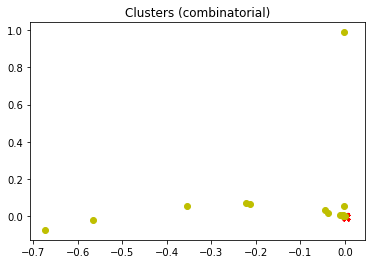

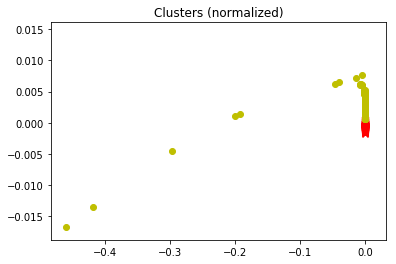

In [214]:
# Your code here.
fig = plt.figure()
plt.scatter(embeddings_c[clusters_c==1,0],embeddings_c[clusters_c==1,1], label='', color='r', marker='x')
plt.scatter(embeddings_c[clusters_c==-1,0],embeddings_c[clusters_c==-1,1], label='', color='y', marker='o')
plt.title('Clusters (combinatorial)')
plt.show()
plt.close(fig)

fig = plt.figure()
plt.scatter(embeddings_n[clusters_n==1,0],embeddings_n[clusters_n==1,1], label='', color='r', marker='x')
plt.scatter(embeddings_n[clusters_n==-1,0],embeddings_n[clusters_n==-1,1], label='', color='y', marker='o')
plt.title('Clusters (normalized)')
plt.show()
plt.close(fig)

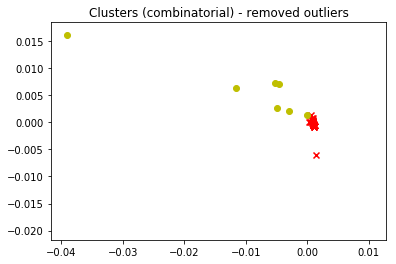

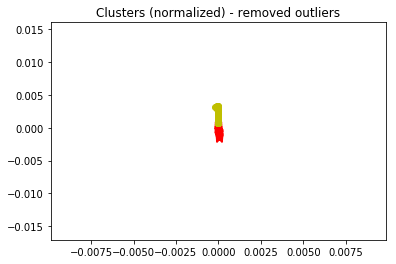

In [215]:
def remove_outliers(embeddings, clusters):
    mean_vec = np.mean(embeddings, axis=0)
    std_vec = np.std(embeddings, axis=0)
    ind_temp = (abs(embeddings - mean_vec)< 2*std_vec)
    ind = np.logical_and(ind_temp[:,0], ind_temp[:,1])
    embeddings_new = embeddings[ind]
    clusters_new = clusters[ind]
    return embeddings_new, clusters_new
embeddings_new_c, clusters_new_c = remove_outliers(embeddings_c, clusters_c)
embeddings_new_n, clusters_new_n = remove_outliers(embeddings_n, clusters_n)

fig = plt.figure()
plt.scatter(embeddings_new_c[clusters_new_c==1,0],embeddings_new_c[clusters_new_c==1,1], label='', color='r', marker='x')
plt.scatter(embeddings_new_c[clusters_new_c==-1,0],embeddings_new_c[clusters_new_c==-1,1], label='', color='y', marker='o')
plt.title('Clusters (combinatorial) - removed outliers')
plt.show()
plt.close(fig)

fig = plt.figure()
plt.scatter(embeddings_new_n[clusters_new_n==1,0],embeddings_new_n[clusters_new_n==1,1], label='', color='r', marker='x')
plt.scatter(embeddings_new_n[clusters_new_n==-1,0],embeddings_new_n[clusters_new_n==-1,1], label='', color='y', marker='o')
plt.title('Clusters (normalized) - removed outliers')
plt.show()
plt.close(fig)

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Our answer:**
* For the k=2 case (as in our case), we use the Fiedler vector as features. We cluster the graph according to the sign of the Fiedler vector. We do this because the eigenvectors give us the direction in which the variance is the largest. Therefore we can capture the most information possible using the eigenvectors. 
* Instead of representing the data as a graph, we could have gone the classical machine learning way and used PCA on the song features (for example the MFCC coeffiecents). We could have done clustering on these features. 